In [ ]:
pip install -q -U keras_tuner

     |████████████████████████████████| 98 kB 3.7 MB/s 


In [ ]:
# Import libraries
import sys, glob, os, time
import numpy as np
import scipy as sp
import pandas as pd
from csv import reader, writer
import joblib
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Activation, Input, Dense, Dropout, Conv2D, Conv2DTranspose, BatchNormalization, UpSampling2D, Reshape, LeakyReLU
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.generic_utils import get_custom_objects
import keras_tuner as kt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython import display

get_custom_objects().update({'leaky-relu': Activation(LeakyReLU(alpha=0.2))})

In [ ]:
# Activate GPU
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
# current working directory
cwd = '/content/drive/MyDrive/Colab Notebooks/Daylight Autonomy/'

# Define Functions

In [ ]:
class GenerateImage(keras.callbacks.Callback):
    def __init__(self, xtrain, ytrain, xtest, ytest, monitor_idx):
        self.xtrain = xtrain
        self.ytrain = ytrain
        self.xtest = xtest
        self.ytest = ytest
        self.monitor_idx = [monitor_idx]
    
    def on_epoch_end(self, epoch, logs={}):
        train_sim = self.ytrain[self.monitor_idx]
        train_pred = self.model.predict(self.xtrain[self.monitor_idx])
        test_sim = self.ytest[self.monitor_idx]
        test_pred = self.model.predict(self.xtest[self.monitor_idx])

        fig, ax = plt.subplots(2, 2, figsize=(6, 6))
        display.clear_output(wait=True)

        ax[0, 0].imshow(train_pred[0,:,:,0], cmap='RdYlBu_r', vmin=0, vmax=100)
        ax[0, 1].imshow(train_sim[0,:,:], cmap='RdYlBu_r', vmin=0, vmax=100)
        ax[1, 0].imshow(test_pred[0,:,:,0], cmap='RdYlBu_r', vmin=0, vmax=100)
        ax[1, 1].imshow(test_sim[0,:,:], cmap='RdYlBu_r', vmin=0, vmax=100)

        ax[0,0].set_title('Prediction', size=12)
        ax[0,1].set_title('Simulation', size=12)
        ax[0,0].set_ylabel('Train Sample', size=12)
        ax[1,0].set_ylabel('Test Sample', size=12)

        ax=ax.ravel()
        for a in ax:
            a.set_xticklabels([])
            a.set_yticklabels([])
            a.set_xticks([])
            a.set_yticks([])
        
        plt.savefig(os.path.join(cwd, 'images', 'generated_img', 'image_at_epoch_{:04d}.png'.format(epoch)))
        plt.show()
        plt.close()

In [ ]:
def compare_plot(sim, pred):
    results = [np.sqrt(mean_squared_error(sim[k],pred[k].reshape(30,-1))) for k in range(len(sim))]

    best_mse = min(results)
    best_idx = results.index(best_mse)

    mid_mse = np.mean(results)
    mid_idx = min(range(len(results)), key=lambda i: abs(results[i]-mid_mse))

    worst_mse = max(results)
    worst_idx = results.index(worst_mse)

    fig, ax = plt.subplots(2,3,sharex=True, sharey=True, figsize=(10,7))

    ax[0,0].imshow(sim[best_idx], cmap='RdYlBu_r', vmax=100, vmin=0)
    ax[0,0].set_ylabel('Simulation', size=15)
    ax[0,0].set_title('Best Case: MSE={:.3f}'.format(best_mse), size=15)

    ax[1,0].imshow(pred[best_idx].reshape(30,-1), cmap='RdYlBu_r', vmax=100, vmin=0)
    ax[1,0].set_ylabel('Prediction', size=15)

    ax[0,1].imshow(sim[mid_idx], cmap='RdYlBu_r', vmax=100, vmin=0)
    ax[0,1].set_title('Avg Case: MSE={:.3f}'.format(mid_mse), size=15)

    ax[1,1].imshow(pred[mid_idx].reshape(30,-1), cmap='RdYlBu_r', vmax=100, vmin=0)

    ax[0,2].imshow(sim[worst_idx], cmap='RdYlBu_r', vmax=100, vmin=0)
    ax[0,2].set_title('Worst Case: MSE={:.3f}'.format(worst_mse), size=15)

    ax[1,2].imshow(pred[worst_idx].reshape(30,-1), cmap='RdYlBu_r', vmax=100, vmin=0)

    ax=ax.ravel()
    for a in ax:
        a.set_xticklabels([])
        a.set_yticklabels([])
        a.set_xticks([])
        a.set_yticks([])

    plt.tight_layout()

# Data setup

In [ ]:
features_file = os.path.join(cwd, 'data', 'features.csv')
targets_file = os.path.join(cwd, 'data', 'DA.csv')

In [ ]:
raw_features = pd.read_csv(features_file, index_col=0)
raw_targets = pd.read_csv(targets_file)

In [ ]:
# set domain
minmax = np.array([[-7.5,7.5], [-7.5,7.5], [-7.5,7.5], [-7.5,7.5],
                   [-7.5,7.5], [-7.5,7.5], [-7.5,7.5], [-7.5,7.5],
                   [2,3.5], [0.2,0.95], [0.2,0.95], [0,360]])

In [ ]:
f_avg = minmax.mean(axis=1)
f_std = minmax.std(axis=1)
t_std = 1

In [ ]:
# Normalize data
features = (raw_features - f_avg)/f_std
targets = raw_targets/t_std

In [ ]:
features = np.array(features)
targets = np.array(targets).reshape(len(targets),30,30)

In [ ]:
# Split data to train, validate, test set (60% training, 20% validation, 20% test split)
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=49)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=98)

In [ ]:
n_feat = features.shape[1]
n_tar = targets.shape[1]

# Test Model

In [ ]:
# Clear keras workspace for new model
keras.backend.clear_session()

# Deconvolutional Neural Network Model (DCNN) for generating daylight autonomy
model = Sequential()

### DNN model to analysis the input parameters
model.add(Dense(128 * 6 * 6, input_dim=n_feat))
model.add(BatchNormalization())
model.add(LeakyReLU())

### Deconvolution to generate image
model.add(Reshape((6, 6, 128)))

model.add(Conv2DTranspose(filters=64, kernel_size=4, strides=(2,2)))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Conv2DTranspose(filters=16, kernel_size=4, strides=(2,2)))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Conv2DTranspose(filters=1, kernel_size=3, padding="same"))

# optimizer
model.compile(optimizer=optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999), loss="mse")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4608)              59904     
                                                                 
 batch_normalization (BatchN  (None, 4608)             18432     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4608)              0         
                                                                 
 reshape (Reshape)           (None, 6, 6, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       131136    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       2

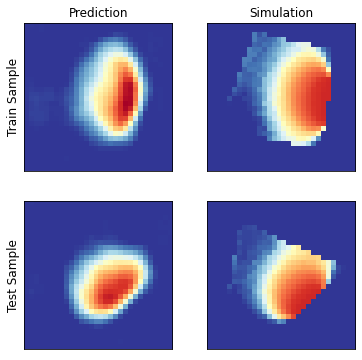

75/75 [==============================] - 1s 8ms/step - loss: 115.5579 - val_loss: 100.4388


In [ ]:
history = model.fit(
    X_train,
    y_train,
    epochs = 50,
    batch_size = 16,
    validation_data = (X_val, y_val),
    callbacks = [
                 EarlyStopping(monitor='val_loss', patience=10, mode='min'),
                 ModelCheckpoint(filepath = 'CNN2D.ckpt', save_weights_only=True, monitor='val_loss', save_best_only=True),
                 GenerateImage(X_train, y_train, X_test, y_test, [95])
    ]
)

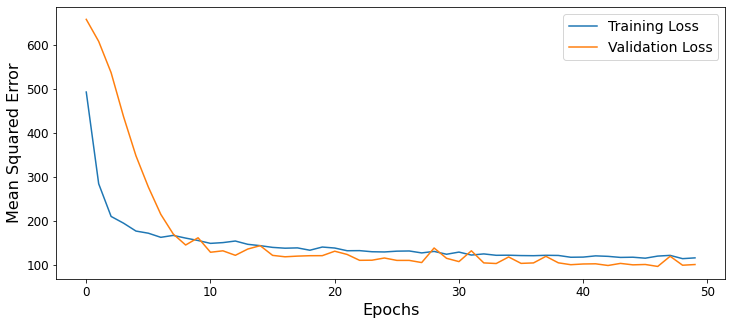

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.ylabel('Mean Squared Error',fontsize=16)
plt.xlabel('Epochs',fontsize=16)
plt.legend(fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.show()

In [ ]:
model.load_weights('CNN2D.ckpt');

In [ ]:
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

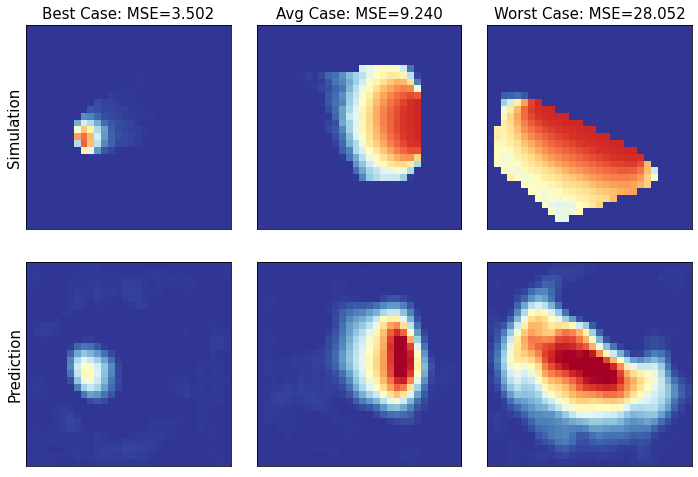

In [ ]:
compare_plot(y_test, y_pred)

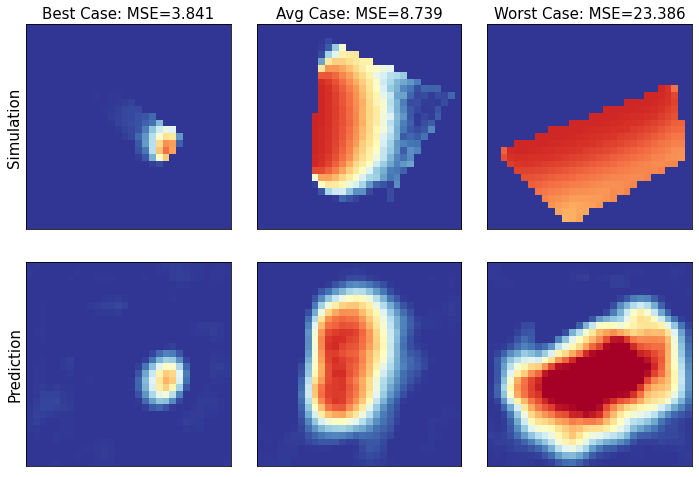

In [ ]:
compare_plot(y_train, y_train_pred)

#Hyperparameter Tuning

In [ ]:
# Contruct dictionary for calucating filter and stride to end with correct image size (30 x 30 x 1)
def construct_layers(hp,n_inputs):
    # initialize
    layers = []
    out = n_inputs
    i = 1

    # Setup transposed CNN layers for hyperparameter tuning
    while out < 30:
        if out < 26:
            ins = {"input":out,
                "kernel":hp.Int('kernel_' + str(i), min_value=2, max_value=5),
                "stride":1,
                "activation":hp.Choice('CNN_act_' + str(i), values=['tanh','relu', 'selu', 'leaky-relu']),
                "filter":hp.Int('filter_'+str(i), min_value=16, max_value=128, step=16)
                }
        else:
            ins = {"input":out,
                "kernel":31 - out,
                "stride":1,
                "activation":hp.Choice('CNN_act_' + str(i), values=['tanh','relu', 'selu', 'leaky-relu']),
                "filter":hp.Int('filter_'+str(i), min_value=16, max_value=128, step=16)
                }
        
        # Calculate output size
        out = (out-1) * ins["stride"] + ins["kernel"]
        i += 1
        ins.update({"output":out})
        layers.append(ins)
    
    return layers

In [ ]:
def generator(hp):
    # Generator model for generating daylight autonomy
    model = Sequential()

    # Setup DNN layers
    DNN_layers = hp.Int('DNN_layers', min_value=0, max_value=4)

    # Setup CNN transpose layers
    hp_initsize = hp.Int('init_size', min_value=5, max_value=9)
    CNN_layers = construct_layers(hp, hp_initsize)

    ### DNN model to analyze the input parameters
    if DNN_layers == 0:
        model.add(Dense(units = CNN_layers[0]["filter"] * hp_initsize * hp_initsize, 
                        activation=hp.Choice('DNN_act_0', values=['tanh', 'relu', 'leaky-relu', 'sigmoid', 'selu']),
                        input_dim=n_feat))
        model.add(BatchNormalization())
    else:
        for i in range(DNN_layers):
            if i == 0:
                model.add(Dense(units = hp.Int('units_' + str(i+1), min_value=16, max_value=256, step=16),
                                activation=hp.Choice('DNN_act_' + str(i+1), values=['relu', 'leaky-relu', 'sigmoid', 'selu']),
                                input_dim=n_feat))
                model.add(BatchNormalization())
            else:
                model.add(Dense(units = hp.Int('units_' + str(i+1), min_value=16, max_value=256, step=16),
                        activation=hp.Choice('DNN_act_' + str(i+1), values=['relu', 'leaky-relu', 'sigmoid', 'selu'])))
                model.add(BatchNormalization())
        model.add(Dense(units = CNN_layers[0]["filter"] * hp_initsize * hp_initsize, 
                        activation=hp.Choice('DNN_act_0', values=['relu', 'leaky-relu', 'sigmoid', 'selu'])))
        model.add(BatchNormalization())

    ### Deconvolution to generate image
    model.add(Reshape((hp_initsize, hp_initsize, CNN_layers[0]["filter"])))

    for layer in CNN_layers:
        model.add(Conv2DTranspose(filters=layer["filter"],
                                  kernel_size=layer["kernel"],
                                  strides=(layer["stride"],layer["stride"]),
                                  activation=layer["activation"]))
        model.add(BatchNormalization())
    
    model.add(Conv2DTranspose(filters=1,
                              kernel_size=hp.Int('kernel_'+str(len(CNN_layers)+1), min_value=2, max_value=5),
                              padding='same'))

    ### Optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])
    hp_epsilon = hp.Choice('epsilon', values=[1e-4, 1e-6, 1e-8])
    hp_beta_1 = hp.Choice('beta_1', values=[0.5, 0.7, 0.9])
    hp_beta_2 = hp.Choice('beta_2', values=[0.99, 0.995, 0.999])
    model.compile(optimizer=optimizers.Adam(learning_rate=hp_learning_rate, 
                                            beta_1=hp_beta_1, beta_2=hp_beta_2,
                                            epsilon=hp_epsilon), 
                  loss="mse"
                  )

    return model

In [ ]:
# Check for correct setup
hp = kt.HyperParameters()
hp.values["model_type"] = "cnn"

test_model = generator(hp)
test_model(X_train)
test_model.summary()

In [ ]:
# Run bayesian optimization
tuner = kt.BayesianOptimization(generator, 
                                objective='val_loss',
                                max_trials=100,
                                overwrite=True)

In [ ]:
tuner.search(X_train,
             y_train,
             epochs = 100,
             batch_size = 16,
             validation_data = (X_val, y_val),
             callbacks=[EarlyStopping(monitor='val_loss', patience=20, mode='min')],
             )

Trial 27 Complete [00h 01m 24s]
val_loss: 65.00556945800781

Best val_loss So Far: 61.762168884277344
Total elapsed time: 02h 03m 44s

Search: Running Trial #28

Hyperparameter    |Value             |Best Value So Far 
DNN_layers        |4                 |4                 
init_size         |9                 |9                 
kernel_1          |5                 |5                 
CNN_act_1         |selu              |relu              
filter_1          |16                |16                
kernel_2          |3                 |3                 
CNN_act_2         |leaky-relu        |leaky-relu        
filter_2          |128               |128               
kernel_3          |3                 |3                 
CNN_act_3         |tanh              |tanh              
filter_3          |16                |32                
kernel_4          |5                 |5                 
CNN_act_4         |leaky-relu        |leaky-relu        
filter_4          |16                |48

KeyboardInterrupt: ignored

In [ ]:
# get hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hp)
model.summary()

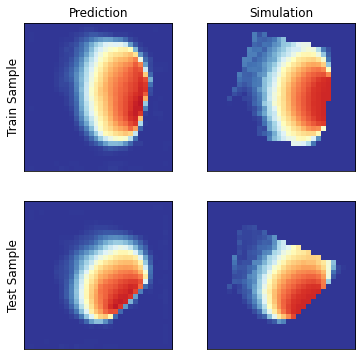

75/75 [==============================] - 1s 14ms/step - loss: 47.0132 - val_loss: 58.7390


In [ ]:
model.fit(X_train,
             y_train,
             epochs = 3000,
             batch_size = 16,
             validation_data = (X_val, y_val),
             callbacks = [EarlyStopping(monitor='val_loss', patience=100, mode='min'),
                          ModelCheckpoint(filepath = 'CNN2D.ckpt', save_weights_only=True, monitor='val_loss', save_best_only=True),
                          GenerateImage(X_train, y_train, X_test, y_test, [95])
                          ]
          )

In [ ]:
model.load_weights('CNN2D.ckpt');

In [ ]:
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

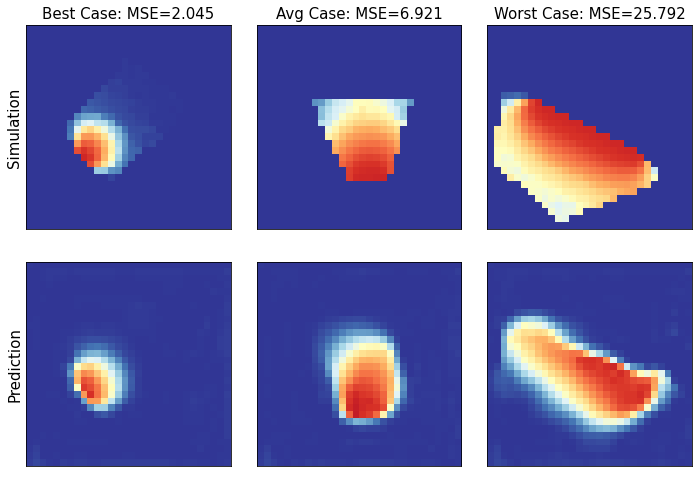

In [ ]:
compare_plot(y_test, y_pred)

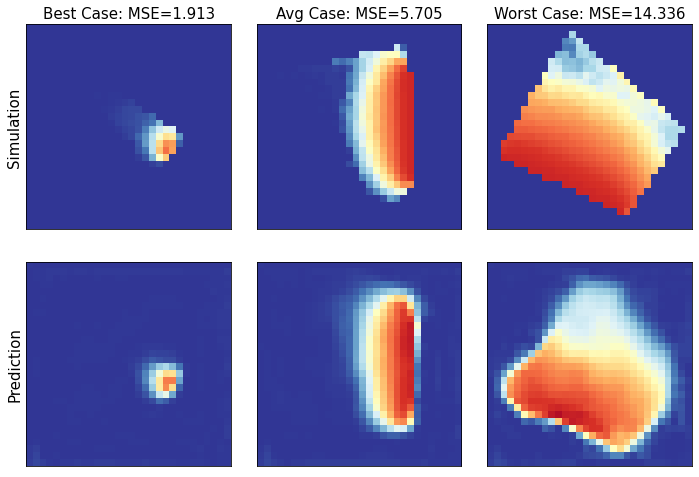

In [ ]:
compare_plot(y_train, y_train_pred)

# Save model

In [ ]:
json = os.path.join(cwd, 'models/DA_model.json')
hdf5 = os.path.join(cwd, 'models/DA_weights.h5')

In [ ]:
model_json = model.to_json()
with open(json,'w') as json_file:
    json_file.write(model_json)
model.save_weights(hdf5)

# Load Model

In [ ]:
json = os.path.join(cwd, 'models/DA_model.json')
hdf5 = os.path.join(cwd, 'models/DA_weights.h5')

In [ ]:
json_file = open(json, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json, custom_objects={'Activation': Activation(LeakyReLU())})
model.load_weights(hdf5)

# Test for random input

In [ ]:
test_case = np.array([4.995933, -3.833014, 3.811166, 4.194472, 
                      -2.381147, 4.912608, -3.419858, -3.496003, 
                      2.341, 0.432, 0.790, 186.615161])

In [ ]:
test_case = (test_case - f_avg)/f_std

test_pred = model.predict(test_case.reshape(1,-1))

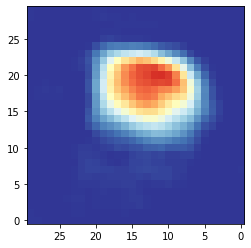

In [ ]:
plt.imshow(test_pred.reshape(30,-1), cmap='RdYlBu_r', vmax=100, vmin=0)